# **NLP Multi-Class Classification on Host Descriptions**

-------
### Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, precision_score

-------
## Reading in the Listings Dataset

In [2]:
listings = pd.read_csv('../data/listings_cleaned.csv')

In [3]:
listings.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,reviews_per_month,city,state,zip_codes,bathrooms,bathrooms_shared,amenities_count,host_verifications_count,private_listing,rating_target
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0.29,Boston,Massachusetts,2128,1.0,0,31,3,1,3
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0.90,Boston,Massachusetts,2119,1.0,0,30,4,1,2


In [4]:
listings['description'].dtype

dtype('O')

In [5]:
def lowercase(description):
    '''function to lowercase all text'''
    
    #lowercase
    description = description.lower()
    return description

# Apply fuction to data
listings['clean_description'] = listings['description'].apply(lowercase)

In [6]:
listings['clean_description'].head(3)

0    fully separate apartment in a two apartment bu...
1    private guest room with private bath, you do n...
2    comfortable,  fully equipped private apartment...
Name: clean_description, dtype: object

------
# **NLP Modeling of the Descriptions**

#### *Start with Naive Bayes - including default hyper paramaters (and small number of features)*

In [7]:
# define X and y
X = listings['clean_description']
y = listings['rating_target']

# determining a baseline accuracy
print(y.value_counts())
print('*'*45)
print(y.value_counts(normalize=True))
print('*'*45)

print(f'Baseline Accuracy: {round(pd.Series(y.value_counts(normalize=True))[2]*100, 2)}%')


2    2713
1    2681
3    2647
4    2623
Name: rating_target, dtype: int64
*********************************************
2    0.254407
1    0.251407
3    0.248218
4    0.245968
Name: rating_target, dtype: float64
*********************************************
Baseline Accuracy: 25.44%


In [8]:
# train test split - stick with the default 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     stratify= y,
                                                    random_state= 42)

In [9]:
print(X_train.shape)
print(X_test.shape)

(7998,)
(2666,)


In [10]:
def build_pipeline(num_features, model_abbrev, instance, X_train, y_train, X_test, y_test ):
    '''
    This function builds a pipeline
    instantiates and fits the model 
    and generates a confusion matrix
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer(max_features = num_features)),
        (model_abbrev, instance)
    ])

    pipe.fit(X_train, y_train)
    print('Train:', pipe.score(X_train, y_train))
    print('Test:', pipe.score(X_test, y_test))

    return plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Reds');

# CVEC and NAIVE Bayes

Train: 0.3557139284821205
Test: 0.3319579894973743


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


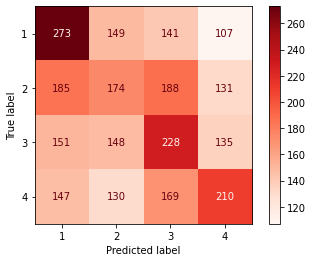

In [19]:
# try same number of features from EDA
build_pipeline(50, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

Train: 0.6587896974243561
Test: 0.5667666916729183


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


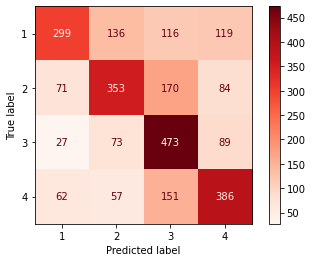

In [21]:
# check with results with many more features
build_pipeline(7000, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

Naive Bayes still underperforming - adding additional vectorized features makes the model over fit and not much of an improvement from the baseline (similar to the model of reviews). 

# CVEC and Logistic Regression

/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train: 0.44248562140535136
Test: 0.4264816204051013


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


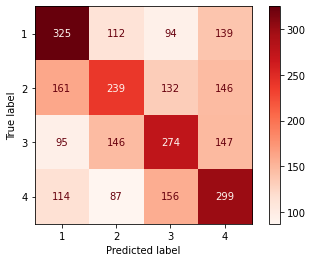

In [22]:
build_pipeline(100, 'logreg', LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs'), X_train, y_train, X_test, y_test)

/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train: 0.8803450862715679
Test: 0.7468117029257314


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


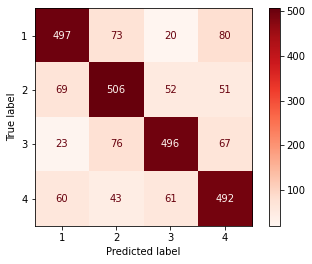

In [23]:
build_pipeline(7000, 'logreg', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'), X_train, y_train, X_test, y_test)

Logistic Regression performing better on the host descriptions than on user reviews. May be an indication that descriptions are a better predictor. Although there's room for the host to exaggerate the quality of their listing, it's becoming clearer that vacationers should pay attention to the effort that host's put into writing lisitng descriptions. 

# CVEC and Random Forest

Train: 0.9114778694673669
Test: 0.7756939234808702


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


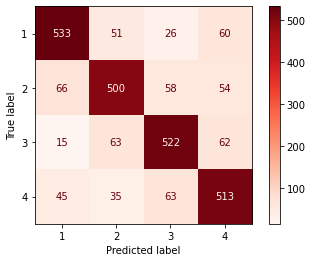

In [38]:
build_pipeline(50, 'rf', RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test)

Train: 0.921980495123781
Test: 0.7843210802700675


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


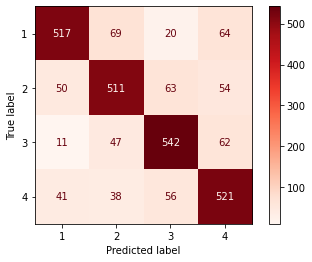

In [39]:
build_pipeline(5000, 'rf', RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test)

The Random Forest model is doing much better on host descriptions than on reviews. It doesn't appear to making a disproportionate amount of errors in predicting any specific class. 

# CVEC and Boosted Model

Train: 0.8945986496624156
Test: 0.7595648912228057


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


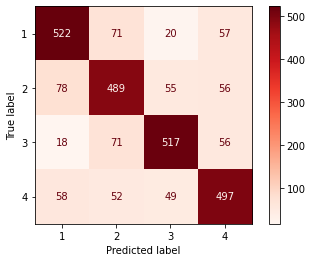

In [40]:
build_pipeline(100, 'ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), X_train, y_train, X_test, y_test)

Train: 0.9089772443110777
Test: 0.7644411102775694


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


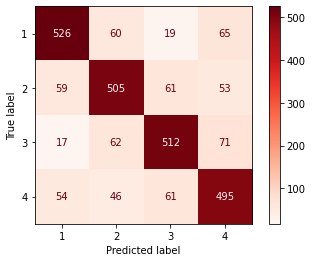

In [41]:
build_pipeline(6000, 'ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), X_train, y_train, X_test, y_test)

Random Forest slightly outperformed the Ada Boost Classifier.

-----
-----
### TF-IDF Vectorizer

In [42]:
def build_pipeline(num_features, model_abbrev, instance, X_train, y_train, X_test, y_test ):
    '''
    This function builds a pipeline
    instantiates and fits the model 
    and generates a confusion matrix
    '''
    pipe = Pipeline([
        ('tvec', TfidfVectorizer(max_features = num_features)),
        (model_abbrev, instance)
    ])

    pipe.fit(X_train, y_train)
    print('Train:', pipe.score(X_train, y_train))
    print('Test:', pipe.score(X_test, y_test))

    return plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Blues');

# TF-IDF and NAIVE Bayes

Train: 0.6782945736434108
Test: 0.5768942235558889


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


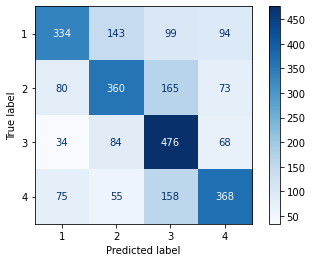

In [43]:
# check with results with many more features
build_pipeline(7000, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

# TF-IDF and Logistic Regression

Train: 0.7779444861215303
Test: 0.6515378844711178


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


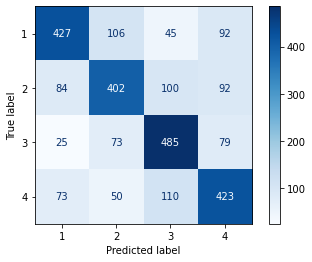

In [44]:
build_pipeline(7000, 'logreg', LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs'), X_train, y_train, X_test, y_test)

# TF-IDF and Random Forest

Train: 0.9232308077019254
Test: 0.7846961740435109


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


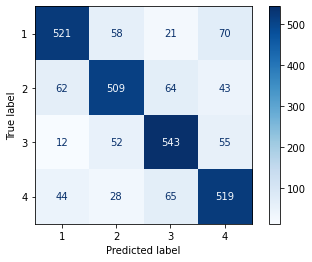

In [63]:
build_pipeline(6000, 'rf', RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test)

The random forest model was still the best model and performed even better with Tf-IDF Vectorizer. Can try to improve/reduce overfitting with a grid search. 

# ***Grid searching***

In [46]:
# best model from above (random forest with Tf-IDF Vectorizer)
# try to improve through a grid search

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

params = {
    'tvec__max_features': [5000, 6000, 7000],
    'tvec__stop_words': [None, 'english'],
    'rf__n_estimators': [100, 200]
}

gs = GridSearchCV(pipe,
                 params,
                 cv = 3,
                 verbose = 1)

In [47]:
# Fit the grid search model
gs.fit(X_train, y_train)

print(f'Training Cross-validated: {gs.best_score_}') # mean cross-validated training score
print(f'Test Score: {gs.score(X_test, y_test)}')

gs.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Training Cross-validated: 0.718304576144036
Test Score: 0.7809452363090773


{'rf__n_estimators': 200,
 'tvec__max_features': 6000,
 'tvec__stop_words': 'english'}

In [50]:
# continuing to fine tune the model
pipe = Pipeline([
    ('tvec', TfidfVectorizer(max_features=6_000, stop_words='english')),
    ('rf', RandomForestClassifier())
])

params = {
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [None, 2, 5, 9],
    'rf__min_samples_leaf': [2, 6, 10]
}

gs = GridSearchCV(pipe,
                 params,
                 cv = 3,
                 verbose = 1)

In [51]:
# Fit the grid search model
gs.fit(X_train, y_train)

print(f'Training Cross-validated: {gs.best_score_}') # mean cross-validated training score
print(f'Test Score: {gs.score(X_test, y_test)}')

gs.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Training Cross-validated: 0.7180545136284072
Test Score: 0.7741935483870968


{'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 300}

------
Writing functions that will stem and lemmatize the comments

In [55]:
# code was inspired by lesson 5.06 on NLP Practice

def stem_review(description):
    
    # split into words
    split_desc = description.split()
    
    # instantiate stemmer
    p_stemmer = PorterStemmer()
    
    # stem and rejoin
    return ' '.join([p_stemmer.stem(word) for word in split_desc])

def lemmatize_review(description):
    
    # split into words
    split_desc = description.split()
    
    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize and rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_desc])

In [58]:
# continuing to fine tune the model
pipe = Pipeline([
    ('tvec', TfidfVectorizer(max_features=6_000, stop_words=None)),
    ('rf', RandomForestClassifier(n_estimators=300, min_samples_leaf= 2))
])

params = {
    'tvec__preprocessor': [None, lemmatize_review, stem_review]
}

gs = GridSearchCV(pipe,
                 params,
                 cv = 5,
                 verbose = 1)

# Fit the grid search model
gs.fit(X_train, y_train)

print(f'Training Cross-validated: {gs.best_score_}') # mean cross-validated training score
print(f'Test Score: {gs.score(X_test, y_test)}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training Cross-validated: 0.7379337867417135
Test Score: 0.777569392348087


-------
### Best Description Model: Random Forest (**78.47% Test Accuracy**)

Train Accuracy: 0.9232308077019254
Test Accuracy: 0.7850712678169542


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


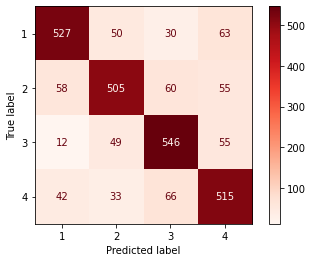

In [17]:
pipe = Pipeline([
        ('tvec', TfidfVectorizer(max_features = 6_000)),
        ('rf', RandomForestClassifier(n_estimators= 300))
    ])

pipe.fit(X_train, y_train)
print('Train Accuracy:', pipe.score(X_train, y_train))
print('Test Accuracy:', pipe.score(X_test, y_test))

plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Reds');

false positives and false negatives have similar cost. Balanced classes - try ROC curve

In [16]:
# in calculating precision for multi-class, need to adjust the 'average' parameter
y_pred = pipe.predict(X_test)
precision_score(y_test, y_pred, average='macro')

0.7861590848995299

In [15]:
y_pred = pipe.predict(X_test)
precision_score(y_test, y_pred, average='micro')

0.7846961740435109

# ROC Curve for analysis